## Applying DNN model on ABIDE dataset


Import neccessary modules for data processing and tensorflow

In [392]:
import os
import numpy as np
from rpy2.robjects.lib.grid import rpy2py

import tensorflow as tf
from tensorflow import keras
import pyreadr
import rpy2.robjects as ro
import rpy2


import pickle

### Load data

Loads preprocessed training and testing data from R's RDS files into a Python environment using rpy2. It extracts predictor variables and a binary outcome variable (where 1 indicates the control, 2 means treatment) from the datasets, converting them to NumPy arrays for use in subsequent model training within Python.

In [405]:
ro.r('train_dat <- readRDS("~/Documents/BCAR/processed_data/train_dat_nn_256.rds")')
ro.r('test_dat <- readRDS("~/Documents/BCAR/processed_data/test_dat_nn_256.rds")')
# Extract data
train_predictors = ro.r('train_dat$predictors')
test_predictors = ro.r('test_dat$predictors')
train_outcome = ro.r('as.integer(I(train_dat$outcome == 2))')
test_outcome = ro.r('as.integer(I(test_dat$outcome == 2))')

train_outcome = np.array(train_outcome)
test_outcome = np.array(test_outcome)

Read the mask file (groupped AAL) and convert it to a NumPy array

In [406]:
# Read mask
AAL_256_Remap = ro.r('readRDS("~/Documents/BCAR/ABIDE_Data/AAL_256_remap.rds")')
AAL_256_Remap_np = np.array(AAL_256_Remap)

### Model

DNN Model consist of 3 layers:
- Input layer: Flatten layer
- Group pooling layer: Custom layer to pool voxel values for each group
- Hidden layer: Dense layer with 256 units and ReLU activation function
- Output layer: Dense layer with 2 units and softmax activation function
- Dropout layer with 0.5 rate
- Compile the model with Adam optimizer, sparse_categorical_crossentropy loss function, and accuracy metric
- Train the model with 20 epochs and batch size of 128

In [408]:
import tensorflow as tf
import numpy as np
from keras.layers import Input, Dense, Dropout, Lambda
from keras.models import Model

# Example: Preloaded 3D parcellation mask
# Replace AAL_256_Remap_np with your actual NumPy 3D array
mask = AAL_256_Remap_np  # Shape: (61, 73, 61)

# Get unique group labels from the mask
unique_labels = np.unique(mask)

# Preprocess the mask to get indices for each group
group_indices = {label: np.argwhere(mask == label) for label in unique_labels}

class GroupPoolingLayer(tf.keras.layers.Layer):
    def __init__(self, group_indices, **kwargs):
        super().__init__(**kwargs)
        self.group_indices = group_indices

    def call(self, inputs):
        # Get batch size dynamically
        batch_size = tf.shape(inputs)[0]
        pooled_outputs = []

        # Iterate over each group and compute pooled values
        for label, indices in self.group_indices.items():
            indices_tensor = tf.convert_to_tensor(indices, dtype=tf.int32)  # Shape: (num_voxels, 3)

            # Expand indices for batch size
            num_voxels = tf.shape(indices_tensor)[0]
            batch_indices = tf.range(batch_size, dtype=tf.int32)  # Shape: (batch_size,)
            batch_indices = tf.reshape(batch_indices, (-1, 1, 1))  # Shape: (batch_size, 1, 1)
            batch_indices = tf.tile(batch_indices, [1, num_voxels, 1])  # Shape: (batch_size, num_voxels, 1)

            # Tile spatial indices for each batch
            indices_tensor = tf.expand_dims(indices_tensor, axis=0)  # Shape: (1, num_voxels, 3)
            indices_tensor = tf.tile(indices_tensor, [batch_size, 1, 1])  # Shape: (batch_size, num_voxels, 3)

            # Concatenate batch indices with spatial indices
            full_indices = tf.concat([batch_indices, indices_tensor], axis=-1)  # Shape: (batch_size, num_voxels, 4)

            # Gather voxel values using full indices
            voxel_values = tf.gather_nd(inputs, full_indices)  # Shape: (batch_size, num_voxels)

            # Compute mean value for the group across voxels
            pooled_value = tf.reduce_mean(voxel_values, axis=1, keepdims=True)  # Shape: (batch_size, 1)
            pooled_outputs.append(pooled_value)

        # Concatenate pooled outputs for all groups
        return tf.concat(pooled_outputs, axis=-1)  # Shape: (batch_size, num_groups)
# Define Model
inputs = Input(shape=(61, 73, 61))  # Adjust input shape
x = GroupPoolingLayer(group_indices)(inputs)  # Apply custom pooling
x = Dense(256, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)  # Output layer for binary classification

# Build the model
keras_model = Model(inputs, outputs)

keras_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
print(keras_model.summary())


Model: "functional_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_76 (InputLayer)     │ (None, 61, 73, 61)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_pooling_layer_20          │ (None, 435)            │             0 │
│ (GroupPoolingLayer)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 256)            │       111,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,130 (438.01 KB)

 Trainable params: 112,130 (438.01 KB)

 Non-trainable params: 0 (0.00 B)

None


Train the model with 20 epochs and batch size of 128

In [409]:

# Train the model
history = keras_model.fit(
    train_predictors,
    train_outcome,
    epochs=20,
    batch_size=128,
    verbose=1
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.4989 - loss: 0.9374
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.4916 - loss: 0.7702
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.5113 - loss: 0.7235
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.5197 - loss: 0.7387
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.4806 - loss: 0.7078
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.4914 - loss: 0.7031
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.5199 - loss: 0.6935
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.5063 - loss: 0.6909
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.5046 - loss: 0.6927
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5188 - loss: 0.6939
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.5224 - loss: 0.6941
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5433 - lo

Evaluate the model on the testing data

In [410]:
test_evaluation = keras_model.evaluate(test_predictors, test_outcome)
predictions =  keras_model.predict(test_predictors)
# predictions = np.argmax(predictions, axis=1)

# Apply the cutoff to classify predictions
cutoff = 0.521
predicted_classes = (predictions[:, 1] >= cutoff).astype(int)
# predicted_classes = np.argmax(predictions, axis=1)
# Check the classified results
print(np.mean(predicted_classes == test_outcome))

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6080 - loss: 0.6830
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 944ms/step
0.6144578313253012


### Evaluation

In [411]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get true labels and predicted probabilities for the positive class
true_labels = test_outcome  # Ground truth labels
predicted_probabilities = predictions[:, 1]  # Probability for positive class


In [412]:
sasbcar_prob_predict_256 = ro.r('readRDS("~/Documents/BCAR/ABIDE_prediction_256/poly20_b100/prob_predict_256.rds")')
sasbcar_prob_predict_256 = np.array(sasbcar_prob_predict_256)
sasbcar_prob_predict_256.shape = (sasbcar_prob_predict_256.shape[0], )

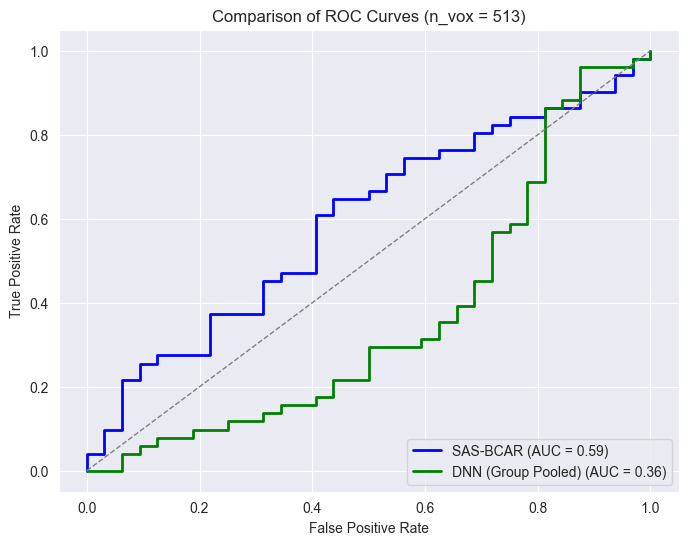

In [413]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# True labels (same for both sets of predictions)
true_labels = test_outcome

# First set of predicted probabilities (sasbcar_prob_predict_256)
fpr_1, tpr_1, _ = roc_curve(true_labels, sasbcar_prob_predict_256)
auc_1 = auc(fpr_1, tpr_1)

# Second set of predicted probabilities (predicted_probabilities)
fpr_2, tpr_2, _ = roc_curve(true_labels, predicted_probabilities)
auc_2 = auc(fpr_2, tpr_2)

# Option 1: Overlay both ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_1, tpr_1, color='blue', lw=2, label=f'SAS-BCAR (AUC = {auc_1:.2f})')
plt.plot(fpr_2, tpr_2, color='green', lw=2, label=f'DNN (Group Pooled) (AUC = {auc_2:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves (n_vox = 513)')
plt.legend(loc="lower right")
plt.show()


In [340]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

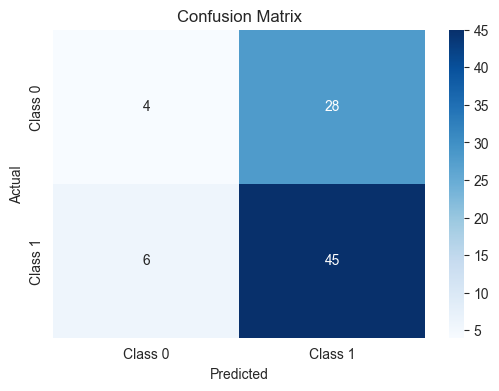

In [375]:
# Compute confusion matrix
cm = confusion_matrix(test_outcome, predicted_classes)
# Define class names
class_names = ['Class 0', 'Class 1']  # Replace with your actual class names if different

# Create a DataFrame for the confusion matrix
import pandas as pd
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plot the confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

